In [5]:
import numpy as np
import sys

try:
    sys.path.insert(0,'../../..')
    import utils
    from config import * 
except:
    print('could not import') 
    
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from scipy import stats
import phate, scprep
sys.path.insert(0,'../EPHATE')

import mds
from sklearn.decomposition import PCA
import phate
from EPHATE.ephate import ephate
np.random.seed(4)
SEED=4
np.random.seed(SEED)
sns.set(context='notebook', style='white')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
fmri_file = './sample_fmri_data.npy'
env_file = './sample_environmental_data.npy'
if os.path.exists(fmri_file):
    X=np.load(fmri_file)
    F=np.load(env_file)
else:    
    event='baseline'
    contrast='nBack_emotion_vs_neutface'
    ROI_name="AMY"
    sublist = utils.select_brain_data_subjects(event ,contrast)[:20]
    if VERBOSE: print(f"loaded {len(sublist)} from sublist")
    data, sublist = utils.load_brain_data(sublist, event, contrast, ROI_name)
    
    N=36
    X=data[:N]
    subs=sublist[:N]
    # build feature matrix
    feature_names = FEATURES_PER_MAT['5']
    variable_names = [PREDICTOR_TO_VARIABLE[f] for f in feature_names]
    F = []
    for f,v in zip(feature_names,variable_names):
        f = stats.zscore(utils.load_variables(subs, event, [f], v, check_reverse=True))
        F.append(f)
    F = np.array(F).T
    np.save(fmri_file, X)
    np.save(env_file, F)
print(F.shape, X.shape)


(36, 5) (36, 573)


# run ephate using the ephate package

In [7]:
ephate_op = ephate.EPHATE(X2_metric='euclidean', n_pca=10, knn=4, t=4, 
                          gamma=-1, random_state=SEED, mds_solver="sgd", knn_dist="euclidean", mds="metric", mds_dist="euclidean",)
embedding0 = ephate_op.fit_transform(X, F)

Calculating fitting EPHATE...
(36, 573) (36, 5) 10
  Running EPHATE on 36 samples; 573 features for view 1 and 5 features for view 2.
  Calculating PHATE graph and diffusion operator...
    Calculating PCA...
    Calculating KNN search...
  Computing pairwise similarity of exogenous features with euclidean metric
  Combining PHATE operator and exogenous matrix operator
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated fitting EPHATE in 0.02 seconds.


/gpfs/milgram/project/casey/elb77/conda_envs/jacked/lib/python3.12/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

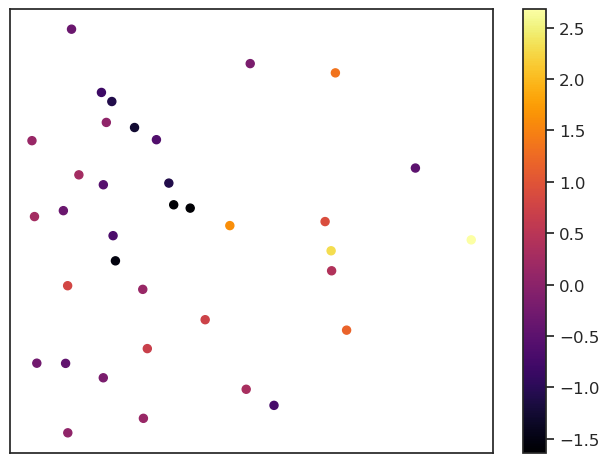

In [8]:
scprep.plot.scatter2d(embedding0, ticks=False, c=F[:,1])

Text(0.5, 1.0, 'ephate phate diffop')

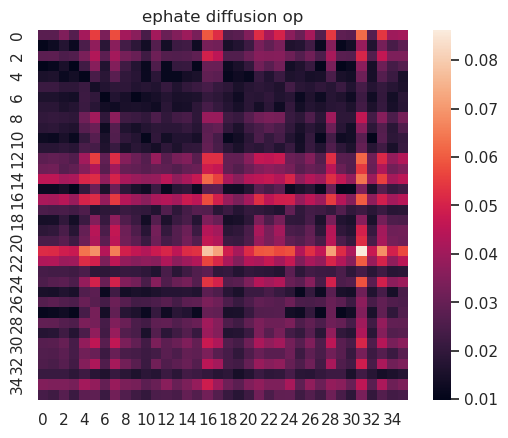

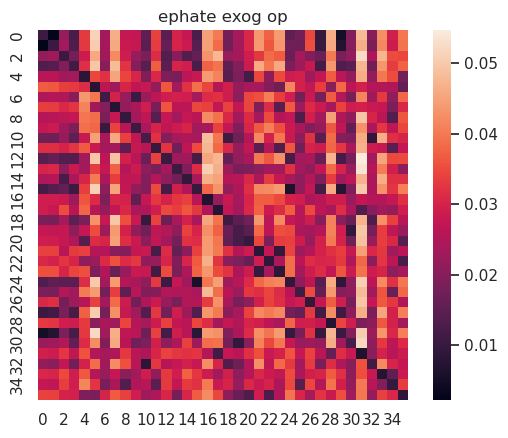

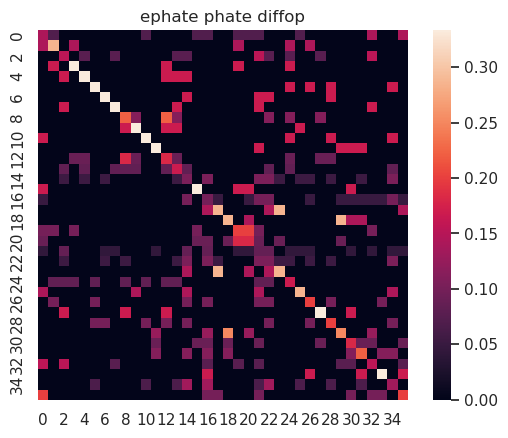

In [9]:
# plot diffusion matrix 
fig,ax=plt.subplots()
sns.heatmap(ephate_op.diff_op, square=True,ax=ax)
ax.set_title('ephate diffusion op')

fig,ax=plt.subplots()
sns.heatmap(ephate_op.exogenous_op, square=True,ax=ax)
ax.set_title('ephate exog op')

fig,ax=plt.subplots()
sns.heatmap(ephate_op.phate_diffop, square=True,ax=ax)
ax.set_title('ephate phate diffop')


# former version of EPHATE manual combination

In [11]:
gamma=-1
t=4
phate_op=phate.PHATE(verbose=0, n_pca=10,knn=4,t=4, decay=None, gamma=gamma, random_state=SEED, 
                     mds_solver="sgd", knn_dist="euclidean", mds="metric", mds_dist="euclidean",)
phate_op.fit(np.nan_to_num(X))

# combined
exog_sim =  ephate_op.exogenous_op
combined_view = np.matmul(phate_op.diff_op.T, exog_sim)

# embed
embedding1 = mds.embed_MDS(combined_view)
diffpot = np.linalg.matrix_power(combined_view, t)

if gamma == 1:
    diff_potential = np.log(diffpot + 1e-7)
elif gamma == -1:
    diff_potential = diffpot
else:
    c = (1 - gamma) / 2
    diff_potential = ((diffpot) ** c) / c

Text(0.5, 1.0, 'regular phate diffop')

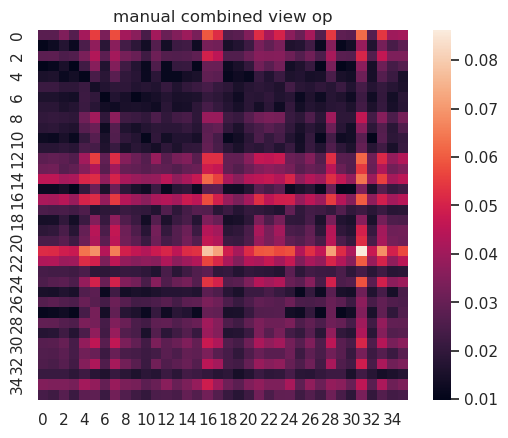

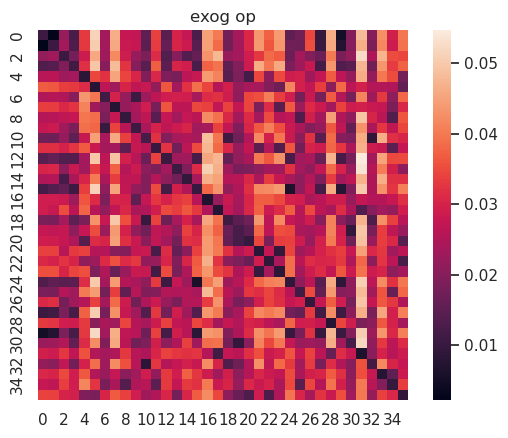

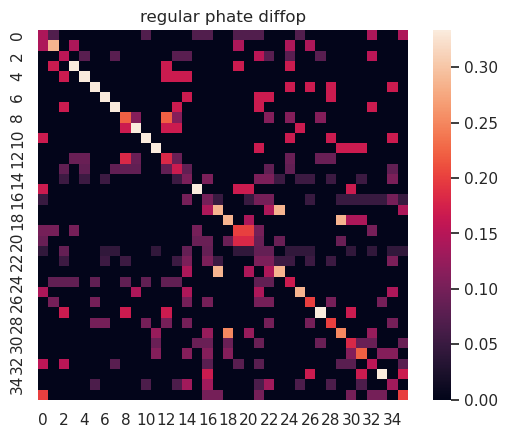

In [12]:
# plot diffusion matrix 
fig,ax=plt.subplots()
sns.heatmap(combined_view, square=True,ax=ax)
ax.set_title('manual combined view op')

fig,ax=plt.subplots()
sns.heatmap(exog_sim, square=True,ax=ax)
ax.set_title('exog op')

fig,ax=plt.subplots()
sns.heatmap(phate_op.diff_op, square=True,ax=ax)
ax.set_title('regular phate diffop')


0.0

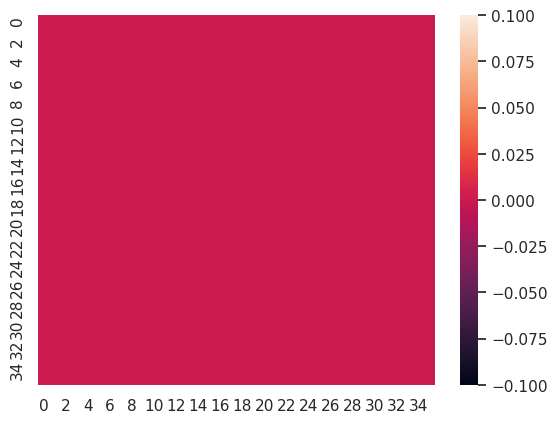

In [13]:
# Match between the combination view used in original analyses and the new package
sns.heatmap(combined_view - ephate_op.diff_op)
np.sum(combined_view - ephate_op.diff_op)